In [1]:
#basic operations
from typing import Union, Tuple, Optional
import os
from tqdm import tqdm
from functools import wraps

#data handling 
import segyio

#math core
import numpy as np
from numpy.random import RandomState


import pylops

import scipy
from scipy.sparse import csc_matrix, linalg
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
def vectorize(func):
    """
    Decorator to make sure the inputs are arrays. We also add a dimension
    to theta to make the functions work in an 'outer product' way.

    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with the arguments transformed to ndarrays.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        vp1 = np.asanyarray(vp1, dtype=float)
        vs1 = np.asanyarray(vs1, dtype=float) + 1e-12  # Prevent singular matrix.
        rho1 = np.asanyarray(rho1, dtype=float)
        vp2 = np.asanyarray(vp2, dtype=float)
        vs2 = np.asanyarray(vs2, dtype=float) + 1e-12  # Prevent singular matrix.
        rho2 = np.asanyarray(rho2, dtype=float)

        new_shape = [-1] + vp1.ndim * [1]
        theta1 = theta1.reshape(*new_shape)
        if (np.nan_to_num(theta1) > np.pi/2.).any():
            raise ValueError("Incidence angle theta1 must be less than 90 deg.")

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper


def preprocess(func):
    """
    Decorator to preprocess arguments for the reflectivity equations.

    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with some arguments transformed.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        # Interpret tuple for theta1 as a linspace.
        if isinstance(theta1, tuple):
            if len(theta1) == 2:
                start, stop = theta1
                theta1 = np.linspace(start, stop, num=stop+1)
            elif len(theta1) == 3:
                start, stop, step = theta1
                steps = (stop / step) + 1
                theta1 = np.linspace(start, stop, num=steps)
            else:
                raise TypeError("Expected 2 or 3 parameters for theta1 expressed as range.")

        # Convert theta1 to radians and complex numbers.
        theta1 = np.radians(theta1).astype(complex)

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper

def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Returns the PP reflection coefficients from the Zoeppritz
    scattering matrix. Wraps zoeppritz_element().

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. Array length n of the exact Zoeppritz solution for the
            specified modes at the interface, at the incident angle theta1.
    """
    return zoeppritz_element(vp1, vs1, rho1, vp2, vs2, rho2, theta1, 'PdPu')


@preprocess
@vectorize
def zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Exact Zoeppritz from expression.

    This is useful because we can pass arrays to it, which we can't do to
    scattering_matrix().

    Dvorkin et al. (2014). Seismic Reflections of Rock Properties. Cambridge.

    Returns the complex reflectivity.

    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    return np.squeeze(rpp)


def reflectivity(vp, vs, rho, theta=0, method='zoeppritz_rpp', axis=0, mode='same'):
    """
    Offset reflectivity, given Vp, Vs, rho, and offset.

    For acoustic reflectivity, use `acoustic_reflectivity()`.

    Computes 'upper' and 'lower' intervals from the three provided arrays,
    then passes the result to the specified method to compute reflection
    coefficients.

    For acoustic reflectivity, either use the `acoustic_reflectivity()`
    function, or call `reflectivity()` passing any log as Vs, e.g. just give
    the Vp log twice (it won't be used anyway):

        reflectivity(vp, vp, rho)

    For anisotropic reflectivity, use either `anisotropy.blangy()` or
    `anisotropy.ruger()`.

    Args:
        vp (ndarray): The P-wave velocity; float or 1D array length m.
        vs (ndarray): The S-wave velocity; float or 1D array length m.
        rho (ndarray): The density; float or 1D array length m.
        theta (ndarray): The incidence angle; float or 1D array length n.
        axis (int): The dimension along which to compute the reflectivity.
        mode (str): 'same' means the output will be the same shape. 'valid'
            means that only strictly valid reflectivities are computed so
            the result will be one sample shorted in the `axis` dimension.
        method (str): The reflectivity equation to use; one of:

            - 'scattering_matrix': scattering_matrix
            - 'zoeppritz_element': zoeppritz_element
            - 'zoeppritz': zoeppritz
            - 'zoeppritz_rpp': zoeppritz_rpp
            - 'akirichards': akirichards
            - 'akirichards_alt': akirichards_alt
            - 'fatti': fatti
            - 'shuey': shuey
            - 'bortfeld': bortfeld
            - 'hilterman': hilterman

        Notes:

            - scattering_matrix gives the full solution
            - zoeppritz_element gives a single element which you specify
            - zoeppritz returns RPP element only; use zoeppritz_rpp instead
            - zoeppritz_rpp is faster than zoeppritz or zoeppritz_element
            - You can also pass a function with the same API as these built-in
                functions.

    Returns:
        ndarray. The result of running the specified method on the inputs.
            Will be a float (for float inputs and one angle), a 1 x n array
            (for float inputs and an array of angles), a 1 x m-1 array (for
            float inputs and one angle), or an m-1 x n array (for array inputs
            and an array of angles).
    """
    methods = {
        'scattering_matrix': scattering_matrix,
        'zoeppritz_rpp': zoeppritz_rpp,

    }
    func = methods.get(method.casefold(), method)
    
    if axis < 0:
        axis = vp.ndim + axis

    if axis > 0:
        vp_  = np.moveaxis(np.asanyarray(vp, dtype=float), axis, 0)
        vs_  = np.moveaxis(np.asanyarray(vs, dtype=float), axis, 0)
        rho_ = np.moveaxis(np.asanyarray(rho, dtype=float), axis, 0)
    else:
        vp_, vs_, rho_ = vp, vs, rho

    if mode == 'same':
        pad_width = [(0, 1)] + (vp.ndim - 1) * [(0, 0)]
        vp_ = np.pad(vp_, pad_width=pad_width, mode='edge')
        vs_ = np.pad(vs_, pad_width=pad_width, mode='edge')
        rho_ = np.pad(rho_, pad_width=pad_width, mode='edge')

    rc = func(vp_[:-1], vs_[:-1], rho_[:-1], vp_[1:], vs_[1:], rho_[1:], theta)

    if axis > 0:
        return np.moveaxis(rc, 0, axis)
    else:
        return np.squeeze(rc)
    
@preprocess
@vectorize
def scattering_matrix(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0):
    """
    Full Zoeppritz solution, considered the definitive solution.
    Calculates the angle dependent p-wave reflectivity of an interface
    between two mediums.

    Originally written by: Wes Hamlyn, vectorized by Agile.

    Returns the complex reflectivity.

    Args:
        vp1 (float): The upper P-wave velocity.
        vs1 (float): The upper S-wave velocity.
        rho1 (float): The upper layer's density.
        vp2 (float): The lower P-wave velocity.
        vs2 (float): The lower S-wave velocity.
        rho2 (float): The lower layer's density.
        theta1 (ndarray): The incidence angle; float or 1D array length n.

    Returns:
        ndarray. The exact Zoeppritz solution for all modes at the interface.
            A 4x4 array representing the scattering matrix at the incident
            angle theta1.
    """
    theta1 *= np.ones_like(vp1)
    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Trans. angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Refl. angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)    # Trans. angle of converted S-wave.

    # Matrix form of Zoeppritz equations... M & N are matrices.
    M = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
                  [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
                  [2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1) ** 2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2) ** 2)],
                  [-rho1 * vp1 * (1 - 2 * np.sin(phi1) ** 2),
                   rho1 * vs1 * np.sin(2 * phi1),
                   rho2 * vp2 * (1 - 2 * np.sin(phi2) ** 2),
                   -rho2 * vs2 * np.sin(2 * phi2)]])

    N = np.array([[np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
                  [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
                  [2 * rho1 * vs1 * np.sin(phi1) * np.cos(theta1),
                   rho1 * vs1 * (1 - 2 * np.sin(phi1) ** 2),
                   2 * rho2 * vs2 * np.sin(phi2) * np.cos(theta2),
                   rho2 * vs2 * (1 - 2 * np.sin(phi2) ** 2)],
                  [rho1 * vp1 * (1 - 2 * np.sin(phi1) ** 2),
                   -rho1 * vs1 * np.sin(2 * phi1),
                   - rho2 * vp2 * (1 - 2 * np.sin(phi2) ** 2),
                   rho2 * vs2 * np.sin(2 * phi2)]])

    M_ = np.moveaxis(np.squeeze(M), [0, 1], [-2, -1])
    A = np.linalg.inv(M_)
    N_ = np.moveaxis(np.squeeze(N), [0, 1], [-2, -1])
    Z_ = np.matmul(A, N_)

    return np.transpose(Z_, axes=list(range(Z_.ndim - 2)) + [-1, -2])


In [3]:
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [4]:
rs = RandomState(42)

nt = 500 #the length of traces

vp, vs, rhob = np.zeros(nt), np.zeros(nt), np.zeros(nt)

thickness = 80
global_variations_amplitude = 300
local_variations_amplitude = 250
trend_slope = 3
vp_trend_intercept = 4000
vs_trend_intercept = 2000

vp_low_frequency_trend = trend_slope*np.arange(nt) + vp_trend_intercept
vs_low_frequency_trend = trend_slope*np.arange(nt) + vs_trend_intercept

for i in range(thickness, nt):
    if not i%thickness:
        vp[i-thickness: i] = rs.randint(-global_variations_amplitude, global_variations_amplitude)
        vs[i-thickness: i] = rs.randint(-global_variations_amplitude+100, global_variations_amplitude-100) 
        rhob[i-thickness: i] = rs.randint(-global_variations_amplitude+100, global_variations_amplitude-100) 
        
vp += rs.normal(loc = 0.00, scale = local_variations_amplitude, size = (nt))
vs += rs.normal(loc = 0.00, scale = local_variations_amplitude-50, size = (nt))
rhob += rs.normal(loc = 0.00, scale = local_variations_amplitude-50, size = (nt))
vp += vp_low_frequency_trend
vs += vs_low_frequency_trend
rhob += vs_low_frequency_trend

rhob /= 1e3
 
vp_smoothed = scipy.ndimage.gaussian_filter(vp, 2)
vs_smoothed = scipy.ndimage.gaussian_filter(vs, 2)
rhob_smoothed = scipy.ndimage.gaussian_filter(rhob, 2)


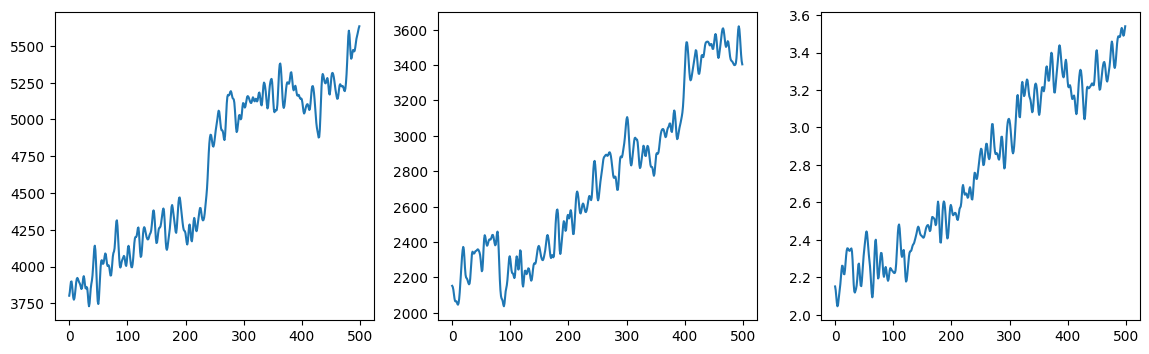

In [5]:
plt.figure(figsize = (14, 4))
plt.subplot(131)
plt.plot(vp_smoothed)

plt.subplot(132)
plt.plot(vs_smoothed)

plt.subplot(133)
plt.plot(rhob_smoothed)

Text(0.5, 1.0, 'Zoeppritz equation modelled traces')

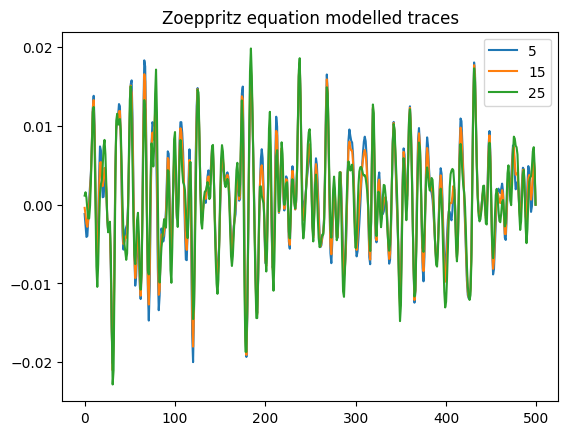

In [6]:
theta = [5, 15, 25]
for i in range(3):
    plt.plot(reflectivity(vp_smoothed, vs_smoothed, rhob_smoothed, method = "zoeppritz_rpp", theta = theta)[i].real, label = "%d" % theta[i])

plt.legend()

plt.title("Zoeppritz equation modelled traces")

In [7]:
curve = []
curve2 = []
vp1 = 5000
vp2 = 2500
vs1 = 2887
vs2 = 1250
rhob1 = 2.75
rhob2 = 2.25

theta = np.arange(0, 91, 1)


for th in theta:
    theta1 = np.radians(th)

    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Trans. angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Refl. angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)  

    pimp1 = vp1*rhob1
    pimp2 = vp2*rhob2
    simp1 = vs1*rhob1
    simp2 = vs2*rhob2

    A = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
            [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
            [np.sin(2*theta1), (vp1/vs1)*np.cos(2*phi1), (simp2*vs2*vp1*np.cos(2*phi1))/(simp1*vs1*vp2), (simp2*vp1*np.cos(2*phi2))/(simp1*vs1)],
            [-np.cos(2*phi1), (vs1/vp1)*np.sin(2*phi1), (pimp2*np.cos(2*phi2))/pimp1, -(simp2*np.sin(2*phi2))/pimp1]], 
            dtype = np.single
        )
    
    b = np.array([np.sin(theta1), np.cos(theta1), np.sin(2*theta1), np.cos(2*phi1)], dtype = np.single)

    res = np.linalg.solve(A,b)
    curve2.append(res[0])
curve = np.array(curve)
print(curve)

[]


In [8]:
from typing import Iterable, Any
from numba import jit


In [9]:
 theta1 = np.radians(theta1, dtype = np.single)

In [10]:
def vectorize(func):
    """
    Decorator to ensure inputs are NumPy arrays, and add a dimension to theta 
    for outer product functionality.

    Handles various input data types, including scalars, lists, tuples, and 
    NumPy arrays. It also adds a small value (epsilon) to vs1 and vs2 to 
    prevent singular matrices.

    Args:
        func (function): The function to vectorize.

    Returns:
        function: The vectorized function.

    Raises:
        TypeError: If any argument cannot be converted to a NumPy array.
        ValueError: If the incidence angle (theta1) exceeds 90 degrees.
    """
    @wraps(func)
    def wrapper(param1, param2, theta1=0, **kwargs):

        param1 = np.array([np.asanyarray(array, dtype=np.single) for array in param1])
        param2 = np.array([np.asanyarray(array, dtype=np.single) for array in param2])

        param1[1] = np.nextafter(param1[1], param1[1] + 1) # Add an epsilon to prevent singular matrix.
        param2[1] = np.nextafter(param2[1], param2[1] + 1) # Add an epsilon to prevent singular matrix.

        new_shape = [-1] + param1[1].ndim * [1]

        theta1 = theta1.reshape(*new_shape)
        if (np.nan_to_num(theta1) > np.pi/2.).any():
            raise ValueError("Incidence angle theta1 must be less than 90 deg.")

        return func(param1, param2, theta1, **kwargs)
    return wrapper


def preprocess(func):
    """
    Decorator to preprocess arguments for reflectivity equations.

    This decorator handles the following:

    - Interprets `theta1` as a tuple representing a range of angles
      and converts it to a linearly spaced array.
    - Converts `theta1` to radians and complex numbers.

    Assumes the function `func` takes `param1`, `param2`, and `theta1`
    as arguments, and potentially additional keyword arguments.

    Args:
        func (function): The reflectivity function to preprocess.

    Returns:
        function: The decorated function with preprocessed arguments.

    Raises:
        TypeError: If `theta1` is a tuple with an invalid number of elements.
    """
    @wraps(func)
    def wrapper(param1, param2, theta1=0, **kwargs):

        # Interpret tuple for theta1 as a linspace.
        if isinstance(theta1, tuple):
            if len(theta1) == 2:
                theta1 = np.linspace(theta1[0], theta1[1], num = theta1[1] + 1)
            elif len(theta1) == 3:
                theta1 = np.linspace(theta1[0], theta1[1], num = (theta1[1] / theta1[2]) + 1)
            else:
                raise TypeError("Expected 2 or 3 parameters for theta1 expressed as range.")

        # Convert theta1 to radians and complex numbers.
        theta1 = np.radians(theta1).astype(np.complex64)

        return func(param1, param2, theta1, **kwargs)
    return wrapper


# @jit(nopython=True)
def scattering_matrix(param1 : Iterable[Any], 
                      param2 : Iterable[Any], 
                      theta1: Union[int, float] = 0.0) -> np.ndarray:
    
    """
    Calculates the scattering matrix for a two-layer medium.

    Args:
        param1 (Iterable[Any]): Parameters for the upper hemisphere, containing P-wave velocity (vp1), 
                                S-wave velocity (vs1), and density (rhob1).
        param2 (Iterable[Any]): Parameters for the lower hemisphere, containing P-wave velocity (vp2), 
                                S-wave velocity (vs2), and density (rhob2).
        theta1 (Union[int, float], optional): Incident angle of the seismic wave measured from the normal 
                                            to the boundary (in degrees). Defaults to 0.

    Returns:
        np.ndarray: The scattering matrix.

    Source: 
        "Quantative seismology" Aki, Richards, 2002. p. 141

    """
    
    vp1, vs1, rhob1 = param1 # Upper hemisphere parametrization.
    vp2, vs2, rhob2 = param2 # Lower hemisphere parametrization.

    # theta1 = np.single(np.radians(theta1))

    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Transmission angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Reflection angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)  # Transmission angle of S-wave.

    # Construct matrices A and b for solving Ax = b.
    A = np.array([
        [-vp1 * p, -np.cos(phi1), vp2 * p, np.cos(phi2)],
        [np.cos(theta1), -vs1 * p, np.cos(theta2), -vs2 * p],
        [2 * rhob1 * (vs1 ** 2) * p * np.cos(theta1), rhob1 * vs1 * (1 - 2 * ((vs1 * p) ** 2)),
            2 * rhob2 * (vs2 ** 2) * p * np.cos(theta2), rhob2 * vs2 * (1 - 2 * ((vs2 * p) ** 2))],
        [-rhob1 * vp1 * (1 - 2 * ((vs1 * p) ** 2)), 2 * rhob1 * (vs1 ** 2) * p * np.cos(phi1),
            rhob2 * vp2 * (1 - 2 * ((vs2 * p) ** 2)), -2 * rhob2 * (vs2 ** 2) * p * np.cos(phi2)]
    ], dtype=np.single)

    b = np.array([
        [vp1 * p, np.cos(phi1), -vp2 * p, -np.cos(phi2)],
        [np.cos(theta1), -vs1 * p, np.cos(theta2), -vs2 * p],
        [2 * rhob1 * (vs1 ** 2) * p * np.cos(theta1), rhob1 * vs1 * (1 - 2 * ((vs1 * p) ** 2)),
            2 * rhob2 * (vs2 ** 2) * p * np.cos(theta2), rhob2 * vs2 * (1 - 2 * ((vs2 * p) ** 2))],
        [rhob1 * vp1 * (1 - 2 * ((vs1 * p) ** 2)), -2 * rhob1 * (vs1 ** 2) * p * np.cos(phi1),
            -rhob2 * vp2 * (1 - 2 * ((vs2 * p) ** 2)), 2 * rhob2 * (vs2 ** 2) * p * np.cos(phi2)]
    ], dtype=np.single)

    # Solve the linear system Ax = b (same to np.linalg.inv(A)@b).
    return np.linalg.solve(A, b)

@preprocess
@vectorize
@jit(nopython=True)
def PP_zoeprittz(param1 : Iterable[Any], 
           param2 : Iterable[Any], 
           theta1: Union[int, float] = 0.0) -> np.single:
    """
    Calculates the PP-reflection coefficient for a seismic wave propagating across a two-layer anelastic medium.

    Args:
        param1 (Iterable[Any]): Parameters for the upper hemisphere, containing P-wave velocity (vp1), 
                                S-wave velocity (vs1), and density (rhob1).
        param2 (Iterable[Any]): Parameters for the lower hemisphere, containing P-wave velocity (vp2), 
                                S-wave velocity (vs2), and density (rhob2).
        theta1 (Union[int, float], optional): Incident angle of the seismic wave measured from the normal 
                                            to the boundary (in degrees). Defaults to 0.

    Returns:
        float: The PP-reflection coefficient.

    Source: 
        "Quantative seismology" Aki, Richards, 2002. p. 144
    """
    
    vp1, vs1, rhob1 = param1 # Upper hemisphere parametrization.
    vp2, vs2, rhob2 = param2 # Lower hemisphere parametrization.

    # theta1 = np.single(np.radians(theta1))

    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)  # Transmission angle of P-wave.
    phi1 = np.arcsin(p * vs1)    # Reflection angle of converted S-wave.
    phi2 = np.arcsin(p * vs2)  # Transmission angle of S-wave.

    phi1_2sin_sq = 2*np.square(np.sin(phi1))
    phi2_2sin_sq = 2*np.square(np.sin(phi2))

    # Calculate intermediate terms for the PP-reflection coefficient
    a = rhob2 * (1 - phi2_2sin_sq) - rhob1 * (1 - phi1_2sin_sq)
    b = rhob2 * (1 - phi2_2sin_sq) + rhob1 * phi1_2sin_sq
    c = rhob1 * (1 - phi1_2sin_sq) + rhob2 * phi2_2sin_sq
    d = 2 * (rhob2 * np.square(vs2) - rhob1 * np.square(vs1))

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    # Calculate the denominator D for the PP-reflection coefficient
    D = E*F + G*H*np.square(p)

    # Calculate the PP-reflection coefficient
    Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) - H*np.square(p) * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))
    # print(type(Rpp))
    return Rpp

@preprocess
@vectorize
@jit(nopython=True)
def PP_akirich(param1 : Iterable[Any], 
           param2 : Iterable[Any], 
           theta1: Union[int, float] = 0.0) -> np.single:
    
    """
    Calculates the PP-reflection coefficient using a simplified formula based on Aki & Richards.

    Args:
        param1 (Iterable[Any]): Parameters for the upper hemisphere, containing P-wave velocity (vp1), 
                                S-wave velocity (vs1), and density (rhob1).
        param2 (Iterable[Any]): Parameters for the lower hemisphere, containing P-wave velocity (vp2), 
                                S-wave velocity (vs2), and density (rhob2).
        theta1 (Union[int, float], optional): Incident angle of the seismic wave measured from the normal 
                                            to the boundary (in degrees). Defaults to 0.

    Returns:
        float: The PP-reflection coefficient.

    Sources:
        "AVO" Chopra, Castagna, 2014. p. 61

    """
    
    vp1, vs1, rhob1 = param1 # Upper hemisphere parametrization.
    vp2, vs2, rhob2 = param2 # Lower hemisphere parametrization.

    # theta1 = np.single(np.radians(theta1))
    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)

    dvs = vs2 - vs1
    dvp = vp2 - vp1
    drhob = rhob2 - rhob1
    vs = (vs1 + vs2)/2.
    vp = (vp1 + vp2)/2.
    rhob = (rhob1 + rhob2)/2.
    theta = (theta1 + theta2)/2.

    Rpp = 0.5*drhob*(1 - 4*np.square(p*vs))/rhob + dvp/(2*vp*np.square(np.cos(theta))) - (4*dvs*np.square(p*vs))/vs
    
    return Rpp

# @preprocess
# @vectorize
# @jit(nopython=True)
def PP_bortfeld(param1 : Iterable[Any], 
           param2 : Iterable[Any], 
           theta1: Union[int, float] = 0.0) -> np.single:
    
    vp1, vs1, rhob1 = param1 # Upper hemisphere parametrization.
    vp2, vs2, rhob2 = param2 # Lower hemisphere parametrization.

    # theta1 = np.single(np.radians(theta1))


    p = np.sin(theta1) / vp1  # Ray parameter.
    
    phi1 = np.arcsin(p * vs1)    # Reflection angle of converted S-wave.

    term1 = 0.5 * np.log((vp2 * rhob2 * np.cos(theta1)) / (vp1 * rhob1 * np.cos(phi1)))
    
    # Second term of the equation
    term2 = np.square(np.sin(theta1) / vp1)
    
    # Third term: difference of squares of vs1 and vs2
    term3 = np.square(vs1) - np.square(vs2)
    
    # Fourth term: ratio of logarithms of densities and velocities
    term4 = np.log(rhob2 / rhob1) / np.log(vs2 / vs1)
    
    # Combine terms to calculate Rpp
    Rpp = term1 + term2 * term3 * (2 + term4)
    
    return Rpp

# @jit(nopython=True)
def PP_shuey(param1 : Iterable[Any], 
           param2 : Iterable[Any], 
           theta1: Union[int, float] = 0.0) -> np.single:
    
    vp1, vs1, rhob1 = param1 # Upper hemisphere parametrization.
    vp2, vs2, rhob2 = param2 # Lower hemisphere parametrization.

    # theta1 = np.single(np.radians(theta1))

    p = np.sin(theta1) / vp1  # Ray parameter.
    theta2 = np.arcsin(p * vp2)

    gamma = vs1/vp1

    poisson1 = (np.square(vp1) - 2*np.square(vs1))/(2*(np.square(vp1) - np.square(vs1)))
    
    poisson2 = (np.square(vp2) - 2*np.square(vs2))/(2*(np.square(vp2) - np.square(vs2)))

    poisson = ((1/np.square(gamma)) - 2)/(2*((1/np.square(gamma)) - 1))

    vp = (vp1 + vp2)/2.
    rhob = (rhob1 + rhob2)/2.
    theta = (theta1 + theta2)/2.

    dvp = vp2 - vp1
    dpoisson = poisson2 - poisson1
    drhob = rhob2 - rhob1

    R0 = 0.5*(dvp/vp + drhob/rhob)
    # B = (dvp/vp)/((dvp/vp) + (drhob/rhob))
    B = 2*(dvp/vp)/R0
    A0 = B - (2*(1 + B)*(1 - 2*poisson)/(1 - poisson))

    RH = (A0*R0 + (dpoisson/np.square(1 - poisson)))

    Rpp = R0 + RH*np.square(np.sin(theta)) + 0.5*(dvp/vp)*(np.square(np.tan(theta))) - np.square(np.sin(theta))
    
    return Rpp



In [11]:
%timeit -n 50000  PP_shuey([vp1, vs1, rhob1], [vp2, vs2, rhob2], th)

15.1 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 50,000 loops each)


In [12]:
# vp1 = 5000.
# vp2 = 2500.
# vs1 = 2887.
# vs2 = 1250.
# rhob1 = 2.75
# rhob2 = 2.25

# vp1 = 2987.
# vp2 = 3810.
# vs1 = 1422.
# vs2 = 2005.
# rhob1 = 2.5
# rhob2 = 2.45

# top (Chopra)

vp1 = 3050.
vp2 = 2440.
vs1 = 1245.
vs2 = 1625.
rhob1 = 2.4
rhob2 = 2.14

# vp1 = 3000.
# vp2 = 4000.
# vs1 = 1800.
# vs2 = 2500.
# rhob1 = 2.2
# rhob2 = 2.4

theta = np.radians(np.arange(0, 51, 1))
param1 = np.array([vp1, vs1, rhob1], dtype = float)
param2 = np.array([vp2, vs2, rhob2], dtype = float)

curve = np.array([scattering_matrix([vp1, vs1, rhob1], [vp2, vs2, rhob2], th)[0, 0] for th in theta], dtype = np.single)

curve3 = np.array([PP_zoeprittz(param1, param2, th).real for th in theta], dtype = np.single)

curve4 = np.array([PP_akirich(param1, param2, th).real for th in theta], dtype = np.single)

curve5 = np.array([PP_bortfeld(param1, param2, th) for th in theta], dtype = np.single)

curve6 = np.array([PP_shuey(param1, param2, th) for th in theta], dtype = np.single)


# bottom

vp2 = 3050
vp1 = 2440
vs2 = 1245
vs1 = 1625
rhob2 = 2.4
rhob1 = 2.14

param1 = np.array([vp1, vs1, rhob1], dtype = float)
param2 = np.array([vp2, vs2, rhob2], dtype = float)

line = np.array([scattering_matrix([vp1, vs1, rhob1], [vp2, vs2, rhob2], th)[0, 0] for th in theta], dtype = np.single)

line3 = np.array([PP_zoeprittz(param1, param2, th).real for th in theta], dtype = np.single)

line4 = np.array([PP_akirich(param1, param2, th).real for th in theta], dtype = np.single)

line5 = np.array([PP_bortfeld(param1, param2, th) for th in theta], dtype = np.single)

line6 = np.array([PP_shuey(param1, param2, th) for th in theta], dtype = np.single)


# print(curve)

In [13]:
param1.shape

(3,)

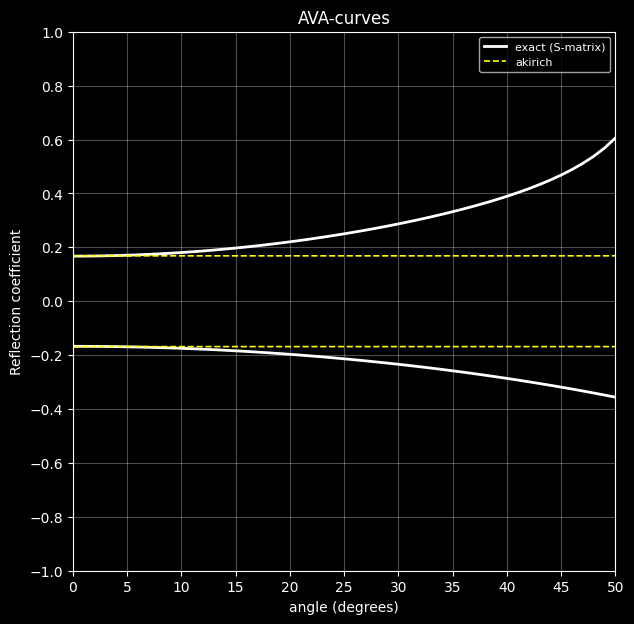

In [14]:
plt.style.use("dark_background")
plt.figure(figsize = (7, 7))
plt.plot(np.rad2deg(theta), curve, lw = 2, c = "white", label = "exact (S-matrix)")
# plt.plot(np.rad2deg(theta), curve3, c = "red",label = "shortened")

plt.plot(np.rad2deg(theta), curve4, c = "yellow",label = "akirich", ls = "--", lw = 1.2)

# plt.plot(np.rad2deg(theta), curve5, c = "purple",label = "bortfeld", ls = "--", lw = 1.2)

# plt.plot(np.rad2deg(theta), curve6, c = "pink",label = "shuey", ls = "--", lw = 1.2)

plt.plot(np.rad2deg(theta), line, lw = 2, c = "white")

plt.plot(np.rad2deg(theta), line4, c = "yellow", ls = "--", lw = 1.2)

# plt.plot(np.rad2deg(theta), line5, c = "purple", ls = "--", lw = 1.2)

# plt.plot(np.rad2deg(theta), line6, c = "pink", ls = "--", lw = 1.2)
plt.grid(alpha = .3)
plt.xticks(np.arange(0, 91, 5))
plt.xlim([0, 50])
plt.title("AVA-curves")
plt.xlabel("angle (degrees)")
plt.ylabel("Reflection coefficient")
# plt.ylim([0, 0.15])
# plt.yticks(np.arange(0, 0.16, 0.05))

plt.ylim([-1, 1])
plt.yticks(np.arange(-1, 1.01, 0.2))
plt.legend(fontsize = 8)

In [15]:
np.squeeze(curve[:2])

array([-0.16731517, -0.16738968], dtype=float32)

In [16]:
vp1 = np.arange(3000, 4000, 1, dtype = np.double)
vp2 = vp1[1:]
vp1 = vp1[:-1]

vs1 = np.arange(2000, 3000, 1, dtype = np.double)
vs2 = vs1[1:]
vs1 = vs1[:-1]

rhob1 = np.arange(2, 3, 0.001, dtype = np.double)
rhob2 = rhob1[1:]
rhob1 = rhob1[:-1]

theta = 5*np.ones(vs1.shape)

In [17]:
def rpp_trace(vp, vs, rhob, theta, mode : str = "same", axis = 0,
              method : str  = "PP_akirich"):

    methods = {
        "pp_akirich": PP_akirich,
        "pp_zoeprittz": PP_zoeprittz
    }
    theta = np.array(theta)

    func = methods.get(method.casefold(), method)
    
    if axis < 0:
        axis = vp.ndim + axis

    if axis > 0:
        vp_  = np.moveaxis(np.asanyarray(vp, dtype = np.single), axis, 0)
        vs_  = np.moveaxis(np.asanyarray(vs, dtype = np.single), axis, 0)
        rhob_ = np.moveaxis(np.asanyarray(rhob, dtype = np.single), axis, 0)
    else:
        vp_, vs_, rhob_ = vp, vs, rhob

    if mode == 'same':
        pad_width = [(0, 1)] + (vp.ndim - 1) * [(0, 0)]
        vp_ = np.pad(vp_, pad_width=pad_width, mode='edge')
        vs_ = np.pad(vs_, pad_width=pad_width, mode='edge')
        rhob_ = np.pad(rhob_, pad_width=pad_width, mode='edge')

    rpp = func([vp_[:-1], vs_[:-1], rhob_[:-1]], [vp_[1:], vs_[1:], rhob_[1:]], theta)

    if axis > 0:
        return np.moveaxis(rpp, 0, axis)
    else:
        return np.squeeze(rpp)




(-0.001, 0.005)

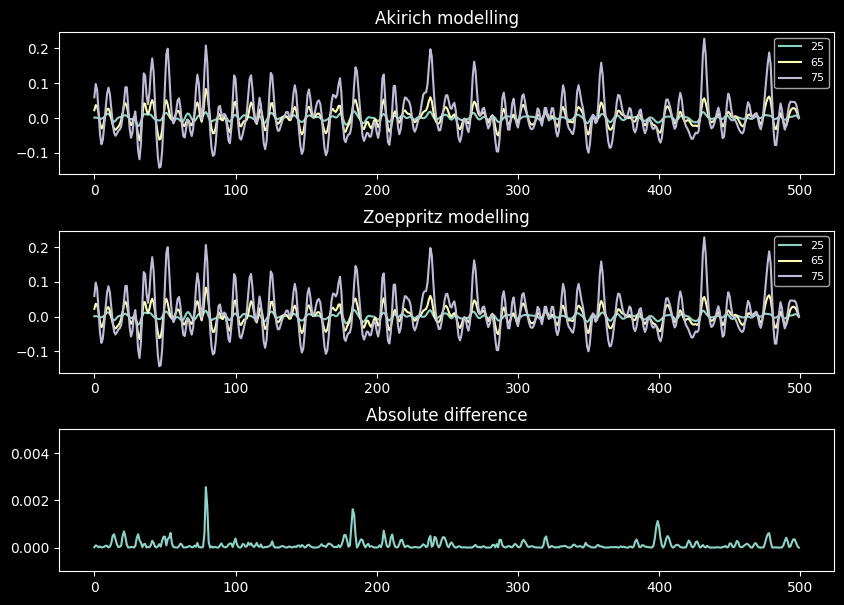

In [18]:
theta = [25, 65, 75]
num = 70
plt.figure(figsize = (10, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.subplot(311)
plt.title("Akirich modelling")
tr1 = []
for i in range(3):
    tr1.append(rpp_trace(vp_smoothed, vs_smoothed, rhob_smoothed, method = "pp_akirich", theta =  theta[i]).real)
    plt.plot(tr1[i], label = "%d" % theta[i])
plt.legend(fontsize = 8)

plt.subplot(312)
plt.title("Zoeppritz modelling")
tr2 = []
for i in range(3):
    tr2.append(reflectivity(vp_smoothed, vs_smoothed, rhob_smoothed, method = "zoeppritz_rpp", theta = theta[i]).real)
    plt.plot(tr2[i], label = "%d" % theta[i])
plt.legend(fontsize = 8)

plt.subplot(313)
plt.title("Absolute difference")
plt.plot(np.abs(tr1[2] - tr2[2]))
plt.ylim([-0.001, 0.005])

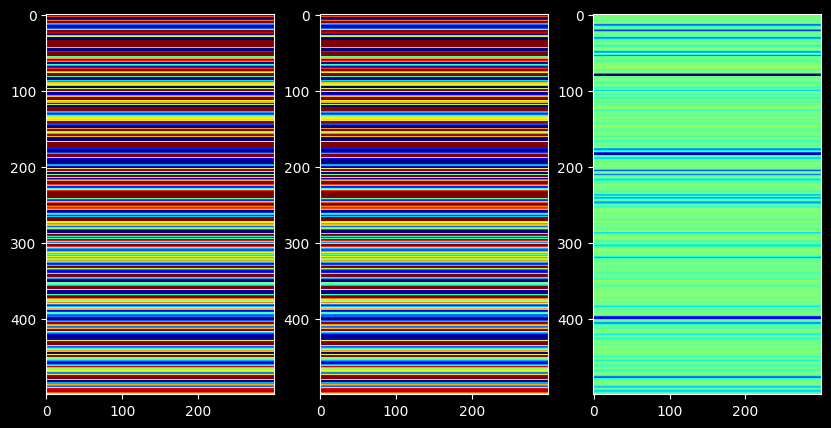

In [19]:
plt.figure(figsize = (10, 5))
plt.subplot(131)
plt.imshow(np.array([tr1[2] for i in range(300)]).T, 
           clim = [-0.05, 0.05], cmap = "jet")

plt.subplot(132)
plt.imshow(np.array([tr2[2] for i in range(300)]).T, 
           clim = [-0.05, 0.05], cmap = "jet")

plt.subplot(133)
plt.imshow(np.array([tr2[2] - tr1[2] for i in range(300)]).T,
           clim = [-0.001, 0.001], cmap = "jet")